In [ ]:
%matplotlib inline
from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)

2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("jpg"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

5243


In [ ]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (RGB)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(195, 240)


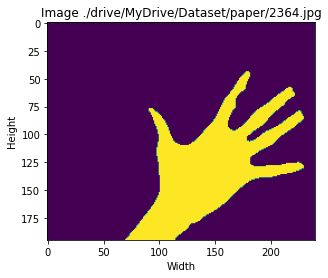

In [ ]:
plot_image(imagepaths[0]) #We plot the first image from our imagepaths array

In [ ]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img)
  
  # Processing label in image path

  # print(path)
  label = path.split("/")[4]
  #label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
  #print(path)
  y.append(label)

print(X[0].shape)

print("done")

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 160, 80, 3) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

(120, 320)
done
Images loaded:  5243
Labels loaded:  5243
paper ./drive/MyDrive/Dataset/paper/2364.jpg


In [ ]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.


y_dict = {}
# y_dict.keys()
k = 0
for i in set(y):
    y_dict[i] = k
    k += 1

for i in range(len(y)):
  y[i] = (y_dict[y[i]])

print(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

# y_train = list(y_train)
# y_test = list(y_test)

a = []
b = []

for i in range(len(y_train)):
    a.append([y_dict[y_train[i]]])

for i in range(len(y_test)):
    b.append([y_dict[y_test[i]]])

y_train = a
y_test = b

y_train = np.array(y_train)
y_test = np.array(y_test)

print(y_train)
print(x_train.shape, len(y_train[0]))

['7' '7' '7' ... '4' '4' '4']
[[8]
 [3]
 [4]
 ...
 [6]
 [6]
 [8]]
(3670, 160, 80, 3) 1


In [ ]:
y_train

array([[8],
       [3],
       [4],
       ...,
       [6],
       [6],
       [8]])

In [ ]:
print((x_train.shape,y_train.shape))
# print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((3670, 160, 80, 3), (3670, 1))
((1573, 160, 80, 3), (1573, 1))


In [ ]:
#Onehot Encoding the labels.
#Since we have 10 classes we should expect the shape[1] of y_train,y_val and y_test to change from 1 to 10
from tensorflow.keras.utils import to_categorical

y_train=to_categorical(y_train)
# y_val=to_categorical(y_val)
y_test=to_categorical(y_test)

#Verifying the dimension after onehot encoding
print((x_train.shape,y_train.shape))
# print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))


((3670, 160, 80, 3), (3670, 10))
((1573, 160, 80, 3), (1573, 10))


In [ ]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [ ]:
#Image Data Augmentation
from keras.preprocessing import image as image_utils
from keras.callbacks import ReduceLROnPlateau

train_generator = image_utils.ImageDataGenerator(rotation_range=2, horizontal_flip=True, zoom_range=.1 )

val_generator = image_utils.ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1)

test_generator = image_utils.ImageDataGenerator(rotation_range=2,  horizontal_flip= True, zoom_range=.1) 

#Fitting the augmentation defined above to the data
train_generator.fit(x_train)
# val_generator.fit(x_val)
test_generator.fit(x_test)

#Learning Rate Annealer
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01,  patience=3, min_lr=1e-5) 

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout

base_MobNet = MobileNet(include_top=False,weights='imagenet',input_shape=(160,80,3),classes=y_train.shape[1])

#Adding the final layers to the above base models where the actual classification is done in the dense layers
model_mobnet = Sequential()
model_mobnet.add(base_MobNet) 
model_mobnet.add(Flatten()) 
model_mobnet.add(Dense(1024,activation=('relu'),input_dim=512))
model_mobnet.add(Dense(512,activation=('relu'))) 
model_mobnet.add(Dense(256,activation=('relu'))) 
#model_mobnet.add(Dropout(.3))
model_mobnet.add(Dense(128,activation=('relu')))
#model_mobnet.add(Dropout(.2))
model_mobnet.add(Dense(10,activation=('softmax')))

# Model Summary
model_mobnet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 5, 2, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 10240)             0         
                                                                 
 dense_15 (Dense)            (None, 1024)              10486784  
                                                                 
 dense_16 (Dense)            (None, 512)               524800    
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                      

In [ ]:
#Compiling the MobileNet model
from tensorflow.keras.optimizers import SGD
batch_size= 100
epochs=30
learn_rate=.001

sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)

model_mobnet.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

#Training
model_mobnet.fit_generator(train_generator.flow(x_train, y_train, batch_size = batch_size), epochs=10, steps_per_epoch = x_train.shape[0]//batch_size, validation_data = val_generator.flow(x_test, y_test, batch_size = batch_size), validation_steps = 250, callbacks = [lrr], verbose = 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/10
36/36 [==============================] - 233s 6s/step - loss: 1.7750 - accuracy: 0.4168 - val_loss: 1.7369 - val_accuracy: 0.4228 - lr: 0.0010
Epoch 2/10
36/36 [==============================] - 199s 6s/step - loss: 0.4886 - accuracy: 0.8468 - lr: 0.0010
Epoch 3/10
36/36 [==============================] - 200s 6s/step - loss: 0.2131 - accuracy: 0.9286 - lr: 0.0010
Epoch 4/10
36/36 [==============================] - 203s 6s/step - loss: 0.1160 - accuracy: 0.9622 - lr: 0.0010
Epoch 5/10
36/36 [==============================] - 200s 6s/step - loss: 0.0907 - accuracy: 0.9706 - lr: 0.0010
Epoch 6/10
36/36 [==============================] - 202s 6s/step - loss: 0.0699 - accuracy: 0.9784 - lr: 0.0010
Epoch 7/10
36/36 [==============================] - 200s 6s/step - loss: 0.0652 - accuracy: 0.9793 - lr: 0.0010
Epoch 8/10
36/36 [==============================] - 203s 6s/step - loss: 0.0476 - accuracy: 0.9838 - lr: 0.0010
Epoch 9/10
36/36 [==============================] - 203s 6s/st

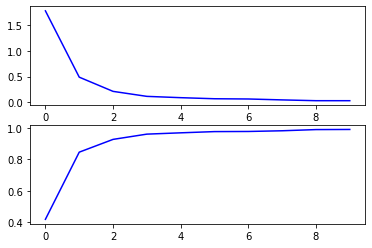

In [ ]:
#Plotting the training and validation loss
f,ax=plt.subplots(2,1) #Creates 2 subplots under 1 column
#Training loss and validation loss
ax[0].plot(model_mobnet.history.history['loss'],color='b',label='Training Loss')
#ax[1].plot(model_mobnet.history.history['val_loss'],color='r',label='Validation Loss')
#Training accuracy and validation accuracy
ax[1].plot(model_mobnet.history.history['accuracy'],color='b',label='Training  Accuracy')
#ax[1].plot(model_mobnet.history.history['val_accuracy'],color='r',label='Validation Accuracy')

In [ ]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):


    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

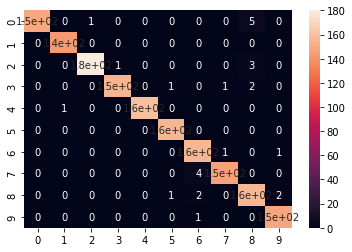

In [ ]:
#Making prediction
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred = model_mobnet.predict(x_test)

y_pred2 = np.argmax(pred, axis=1)


c = []

for i in range(len(y_pred2)):
    c.append(np.array([y_pred2[i]]))
c = np.array(c)

c = to_categorical(c)

y_pred2 = c

# (y_test[0])

#Plotting the confusion matrix
confusion_mtx=confusion_matrix(y_test.argmax(axis=1),y_pred2.argmax(axis=1))

class_names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# #Plotting non-normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred2, classes = class_names,  title = 'Non-Normalized MobileNet Confusion Matrix')
sns.heatmap(confusion_mtx, annot = True)

In [ ]:
#Accuracy of MobileNet 
from sklearn.metrics import accuracy_score
acc2 = accuracy_score(y_test, y_pred2)
print('Accuracy Score of MobileNet = ', acc2)

Accuracy Score of MobileNet =  0.9828353464717101
